  2000 of  5e+05 +  1e+06  0.0016 
  4000 of  5e+05 +  1e+06  0.0016 
  6000 of  5e+05 +  1e+06  0.0016 
  8000 of  5e+05 +  1e+06  0.0016 
 10000 of  5e+05 +  1e+06  0.0016 
 12000 of  5e+05 +  1e+06  0.0016 
 14000 of  5e+05 +  1e+06  0.0016 
 16000 of  5e+05 +  1e+06  0.0003 
 18000 of  5e+05 +  1e+06  0.0003 
 20000 of  5e+05 +  1e+06  0.0003 
 22000 of  5e+05 +  1e+06  0.0003 
 24000 of  5e+05 +  1e+06  0.0003 
 26000 of  5e+05 +  1e+06  0.0004 
 28000 of  5e+05 +  1e+06  0.0004 
 30000 of  5e+05 +  1e+06  0.0004 
 32000 of  5e+05 +  1e+06  0.0004 
 34000 of  5e+05 +  1e+06  0.0005 
 36000 of  5e+05 +  1e+06  0.0005 
 38000 of  5e+05 +  1e+06  0.0005 
 40000 of  5e+05 +  1e+06  0.0005 
 42000 of  5e+05 +  1e+06  0.0005 
 44000 of  5e+05 +  1e+06  0.0005 
 46000 of  5e+05 +  1e+06  0.0005 
 48000 of  5e+05 +  1e+06  0.0005 
 50000 of  5e+05 +  1e+06  0.0005 
 52000 of  5e+05 +  1e+06  0.0005 
 54000 of  5e+05 +  1e+06  0.0005 
 56000 of  5e+05 +  1e+06  0.0005 
 58000 of  5e+05 +  

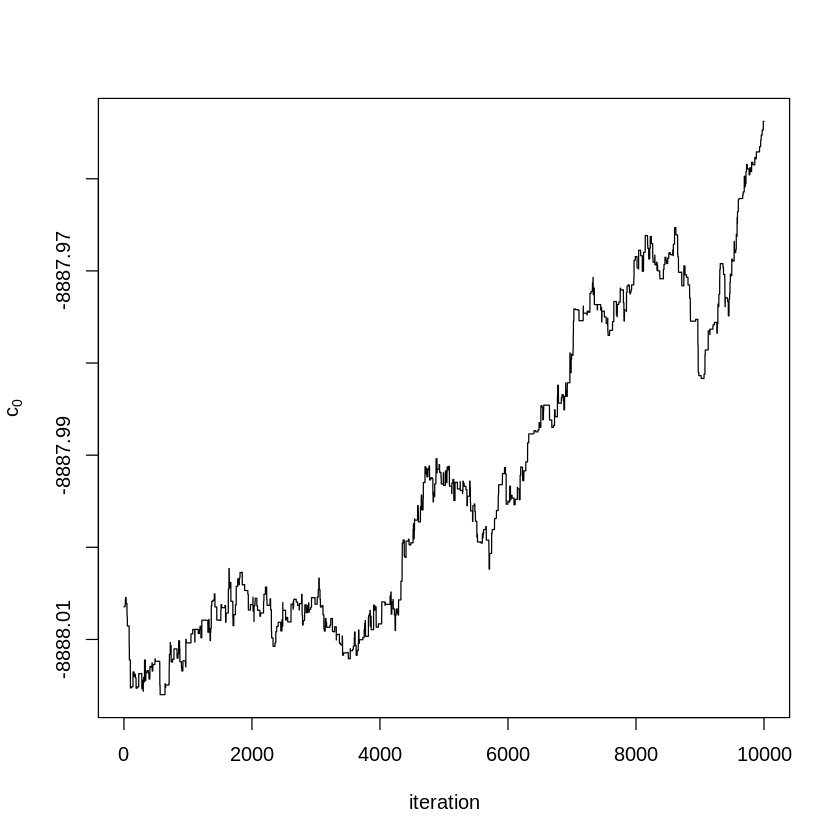

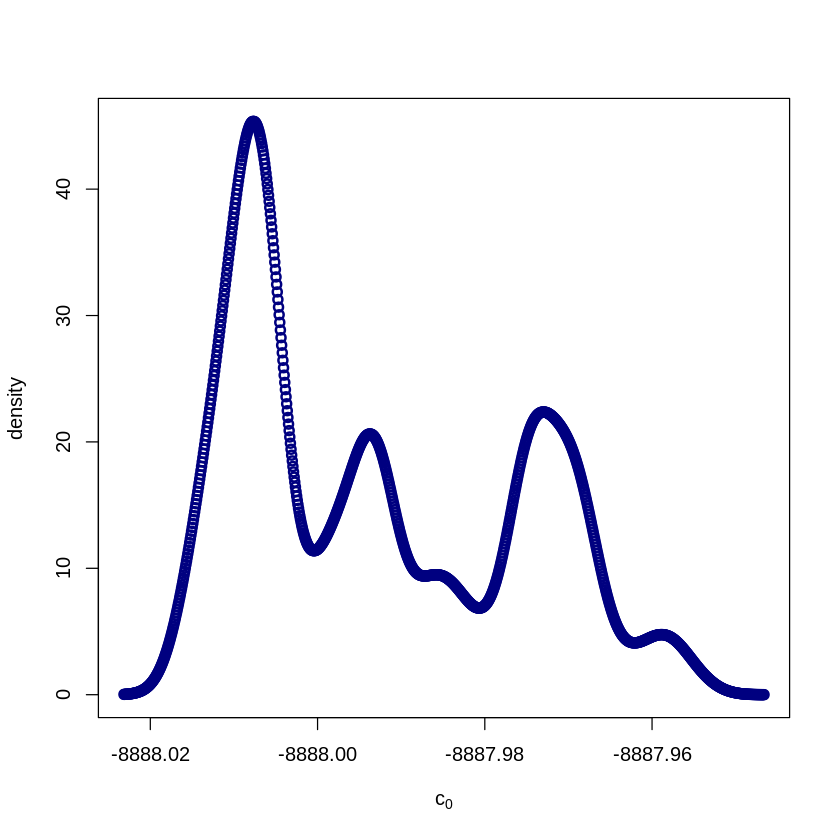

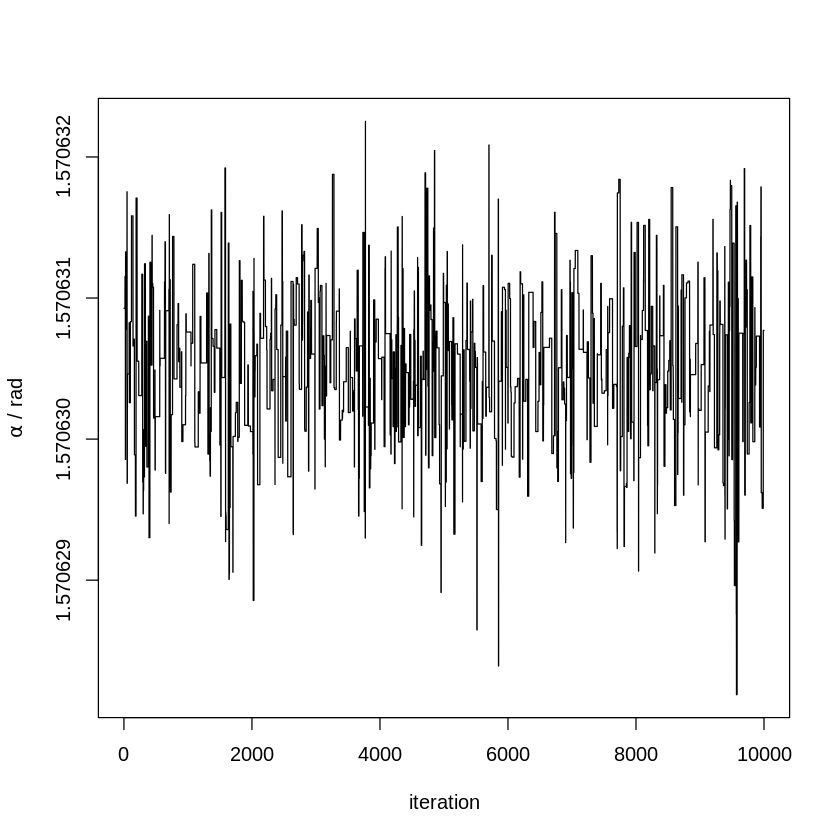

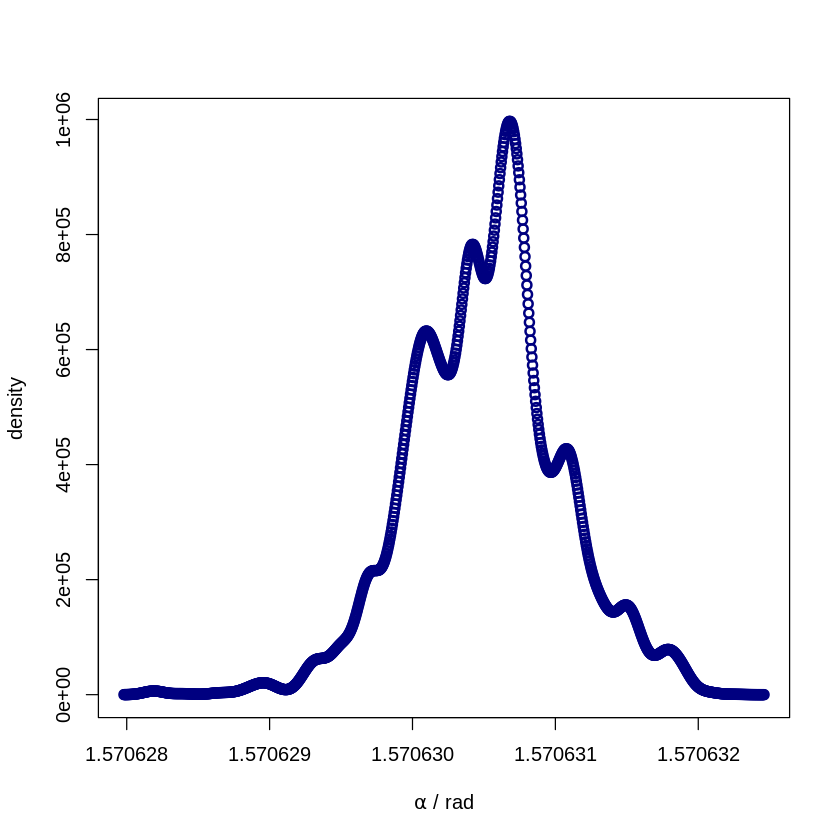

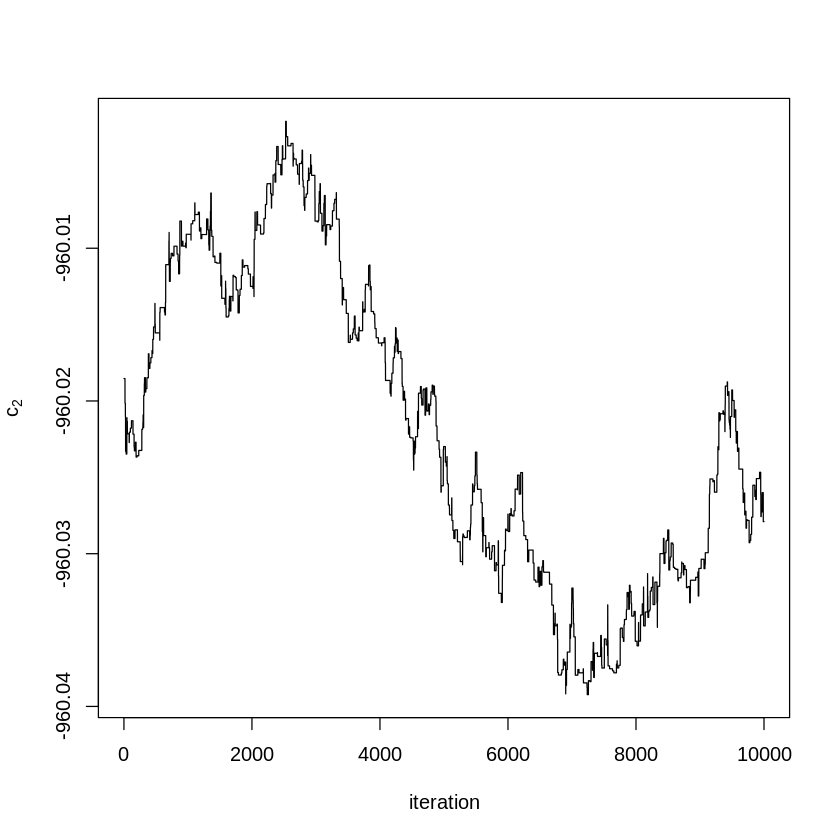

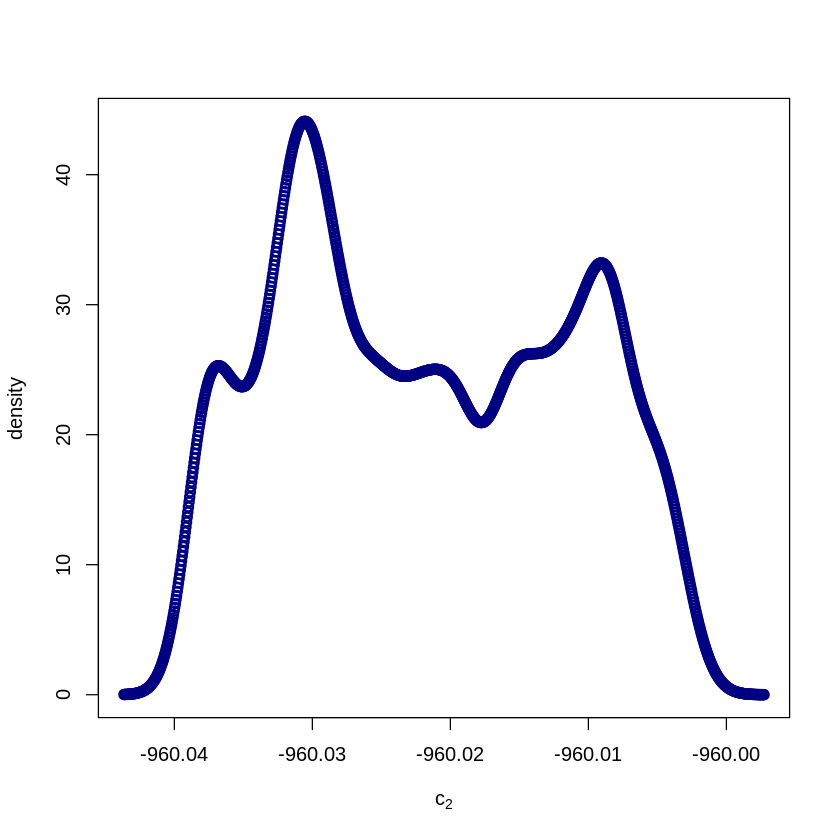

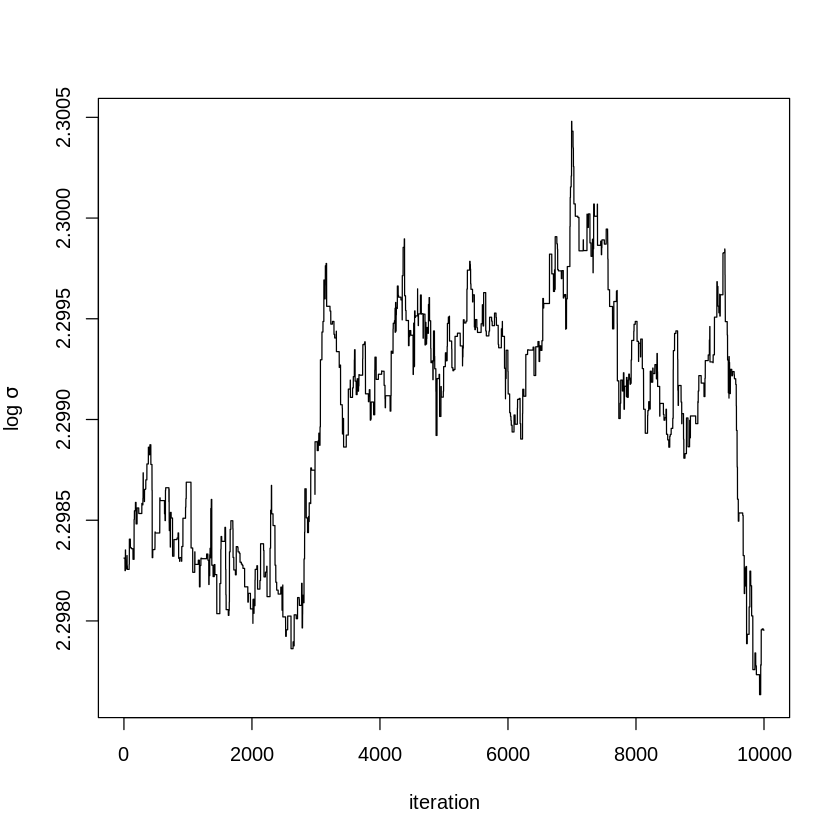

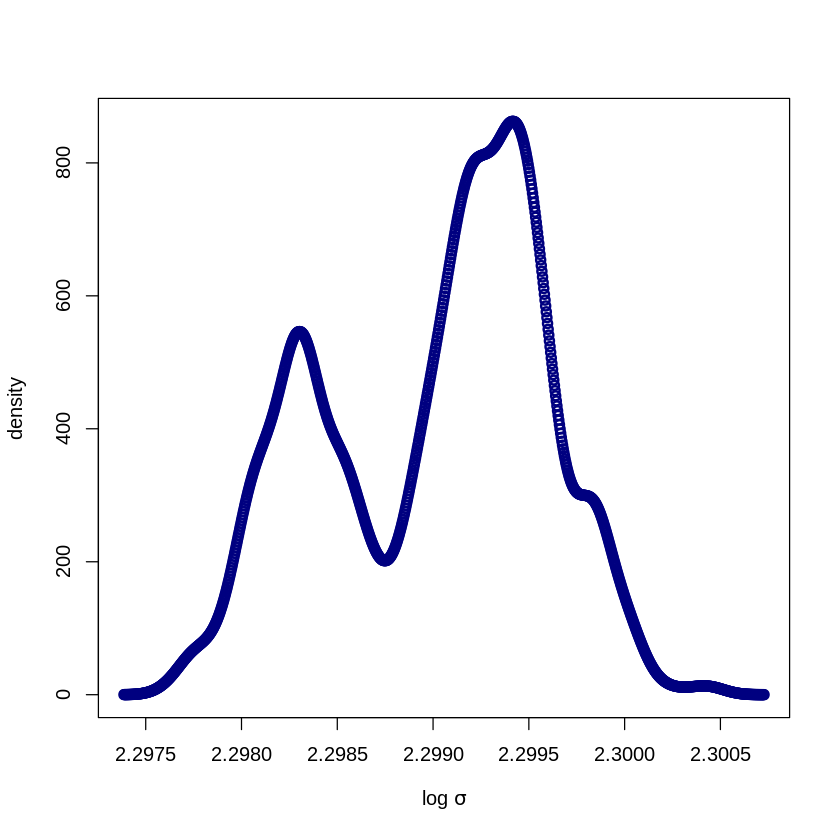

[1] "The prediction for x =" "2.6"                    " is "                  
[4] "303.125517553752"      
[1] "The prediction for x =" "2.8"                    " is "                  
[4] "472.44019156595"       


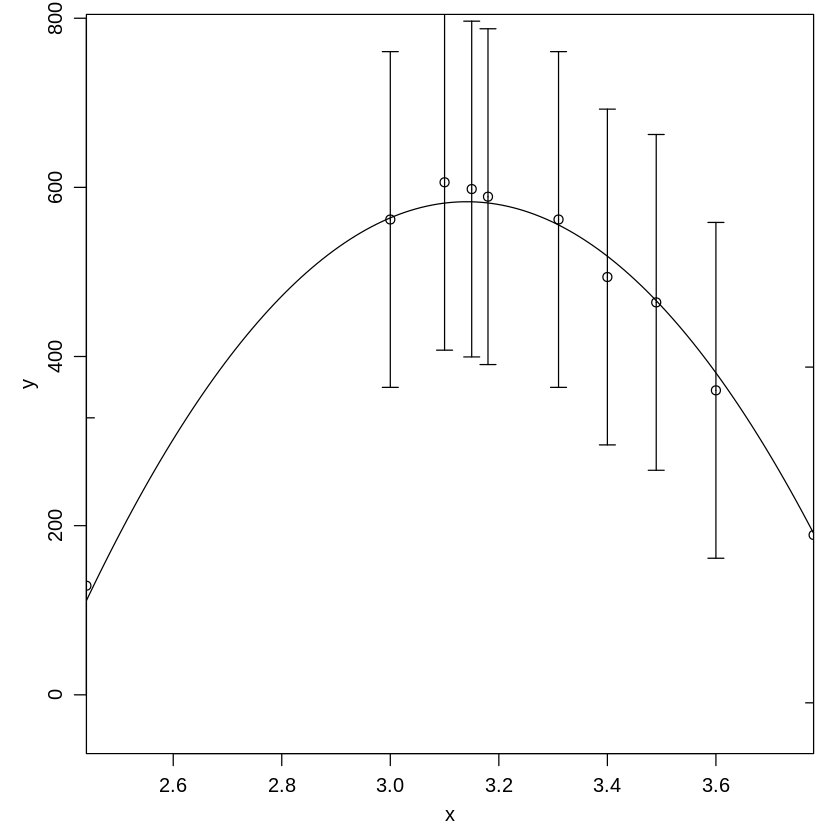

In [56]:
#Ex 1 

#Very long simulation, reduce the number of iterations to repeat it without waiting too long



#install.packages("mvtnorm")
#install.packages("gplots")
library(mvtnorm)
library(gplots)
metrop <- function(func, thetaInit, Nburnin, Nsamp, sampleCov, verbose, 
                   demo=FALSE, ...) {

  Ntheta   <- length(thetaInit)
  thetaCur <- thetaInit
  funcCur  <- func(thetaInit, ...) # log10
  funcSamp <- matrix(data=NA, nrow=Nsamp, ncol=2+Ntheta) 
  # funcSamp will be filled and returned
  nAccept  <- 0
  acceptRate <- 0
  if(demo) {
    thetaPropAll <- matrix(data=NA, nrow=Nsamp, ncol=Ntheta)
  }
  
  for(n in 1:(Nburnin+Nsamp)) {

    # Metropolis algorithm. No Hastings factor for symmetric proposal
    if(is.null(dim(sampleCov))) { # theta and sampleCov are scalars
      thetaProp <- rnorm(n=1, mean=thetaCur, sd=sqrt(sampleCov))
    } else {
      thetaProp <- rmvnorm(n=1, mean=thetaCur, sigma=sampleCov, 
                           method="eigen")
    }
    funcProp  <- func(thetaProp, ...) 
    logMR <- sum(funcProp) - sum(funcCur) # log10 of the Metropolis ratio
    #cat(n, thetaCur, funcCur, ":", thetaProp, funcProp, "\n")
    if(logMR>=0 || logMR>log10(runif(1, min=0, max=1))) {
      thetaCur   <- thetaProp
      funcCur    <- funcProp
      nAccept    <- nAccept + 1
      acceptRate <- nAccept/n
    }
    if(n>Nburnin) {
      funcSamp[n-Nburnin,1:2] <- funcCur
      funcSamp[n-Nburnin,3:(2+Ntheta)] <- thetaCur
      if(demo) {
        thetaPropAll[n-Nburnin,1:Ntheta] <- thetaProp
      }
    }

    # Diagnostics
    if( is.finite(verbose) && (n%%verbose==0 || n==Nburnin+Nsamp) ) {
      s1 <- noquote(formatC(n,          format="d", digits=5, flag=""))
      s2 <- noquote(formatC(Nburnin,    format="g", digits=5, flag=""))
      s3 <- noquote(formatC(Nsamp,      format="g", digits=5, flag=""))
      s4 <- noquote(formatC(acceptRate, format="f", digits=4, width=7, 
                            flag=""))
      cat(s1, "of", s2, "+", s3, s4, "\n")
    }

  }

  if(demo) {
    return(list(funcSamp=funcSamp, thetaPropAll=thetaPropAll))
  } else {
    return(funcSamp)
  }
 
}





x <- c(2.44,3.49,3.78,3.31,3.18,3.15,3.1,3.0,3.6,3.4)
y <- c(129,464,189,562,589,598,606,562,360,494)
obsdata <- data.frame(cbind(x,y))
#plot(x,y)

logprior.quadraticmodel <- function(param) {
    c0Prior       <- dnorm(param[1], mean=-9000, sd=200)
    alphaPrior    <- 1
    c2Prior       <- dnorm(param[3], mean=-1000, sd=100)
    log_sigPrior <- 1
    logPrior <- sum(log10(c0Prior), log10(alphaPrior),log10(c2Prior), log10(log_sigPrior) )
    return(logPrior)
}

loglike.quadraticmodel <- function(param, obsdata) {   # convert alpha to b_1 and log10(ysig) to ysig
    param[2] <- tan(param[2])
    param[4] <- 10^param[4]
    modPred <- drop( param[1:3] %*% t(cbind(1,obsdata$x,obsdata$x^2)) )# Dimensions in mixed vector/matrix products:
                                                                       #[Ndat] = [P] %*% [P x Ndat]
    logLike <- (1/log(10))*sum(dnorm(modPred - obsdata$y, mean=0,sd=param[4], log=TRUE) )
    return(logLike)
}

logpost.quadraticmodel <- function(param, obsdata) {
    logprior <- logprior.quadraticmodel(param)
    if(is.finite(logprior)) { # only evaluate model if parameters are sensible
        return( c(logprior, loglike.quadraticmodel(param, obsdata)) )}
    else {return( c(-Inf, -Inf) )}
}

sampleCov <- diag(c(0.001, 0.001, 0.001, 0.0001)^2)
paramInit <- c(-8888, atan(6060), -960, log10(200))
set.seed(250)
allSamp <- metrop(func=logpost.quadraticmodel , thetaInit=paramInit ,Nburnin=5e5, Nsamp=1e6,sampleCov=sampleCov , verbose=2e3, obsdata=obsdata)

thinSel   <- seq(from=1, to=nrow(allSamp), by=100) # thin by factor 100
postSamp <- allSamp[thinSel ,]

parname <- c(expression(c[0]),expression(paste(alpha, " / rad")),expression(c[2]),expression(paste(log, " ", sigma)))
nr <- nrow(postSamp)
is <- nr-2000

#print(is)
#print(nr)
#print(len(postSamp[is:nr,4]))
for (j in 3:6) {
    plot(1:nrow(postSamp), postSamp[,j],type="l",xlab="iteration",ylab=parname[j-2])
    postDen <- density(postSamp[,j],n=2^10)
    plot(postDen$x, postDen$y,col='navy', lwd = 2,xlab=parname[j-2],ylab="density")
}

posMAP    <- which.max(postSamp[,1]+postSamp[,2]) 
paramMAP  <- postSamp[posMAP, 3:6]
paramMean <- apply(postSamp[,3:6], 2, mean) # Monte Carlo integration

# Overplot MAP solution with original data
par(mfrow=c(1,1), mar=c(3.5,3.5,0.5,1), oma=0.1*c(1,1,1,1), mgp=c(2.0,0.8,0), cex=1.0)
plotCI(obsdata$x, obsdata$y, xaxs="i", yaxs="i", 
       xlab="x", ylab="y", uiw=10^paramMAP[4], gap=0)
xsamp <- seq(from=0, to=5, length.out=500)
#lines(xsamp, drop(ysamp), col="red", lwd=2) # true model
#ysamp <- cbind(1,xsamp,xsamp^2) %*% as.matrix(c(thetaMean[1], tan(thetaMean[2]), thetaMean[3])) 
#lines(xsamp, drop(ysamp), col="green", lwd=2) # mean model
ysamp <- cbind(1,xsamp,xsamp^2) %*% as.matrix(c(paramMAP[1], tan(paramMAP[2]), paramMAP[3]))
lines(xsamp, drop(ysamp)) # MAP model

xnew_v <- c(2.6,2.8)
for (xnew in xnew_v){
    modPred <- cbind(postSamp[,3], tan(postSamp[,4]),postSamp[,5]) %*% t(cbind(1,xnew,xnew^2))
    dy     <- 1
    ymid   <- paramMAP[1] + xnew*tan(paramMAP[2]) + xnew*xnew*paramMAP[3] # to center choice of ycand
    ycand <- seq(ymid-100, ymid+100, dy) # uniform grid of y with step size dy
    ycandPDF <- vector(mode="numeric", length=length(ycand))
    for(k in 1:length(ycand)) {
        like <- dnorm(ycand[k], mean=modPred, sd=10^postSamp[,6]) # [Nsamp x 1]
        ycandPDF[k] <- mean(like) # integration by rectangle rule. Gives a scalar
    }
    peak.ind   <- which.max(ycandPDF)
    yPredDirect <- ycand[c(peak.ind, lower.ind, upper.ind)]
    print(c("The prediction for x =",xnew," is ", yPredDirect[1])) 
}    

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 112
   Unobserved stochastic nodes: 3
   Total graph size: 791

Initializing model


Iterations = 11001:61000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 50000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

      Mean      SD  Naive SE Time-series SE
b0   1.140 0.09283 0.0004152      0.0008054
b1  -1.262 0.15276 0.0006832      0.0012398
tau 39.695 2.15234 0.0096256      0.0239691

2. Quantiles for each variable:

       2.5%    25%    50%    75%   97.5%
b0   0.9545  1.078  1.141  1.204  1.3186
b1  -1.5658 -1.364 -1.260 -1.158 -0.9657
tau 36.1098 37.963 39.923 40.819 44.7186

Press [enter] to continue
Press [enter] to continue
[1] "We can consider the means as the ones given in the summary table and the confidence intervals as the interval between the 2.5 and 97.5 quantiles given in the t

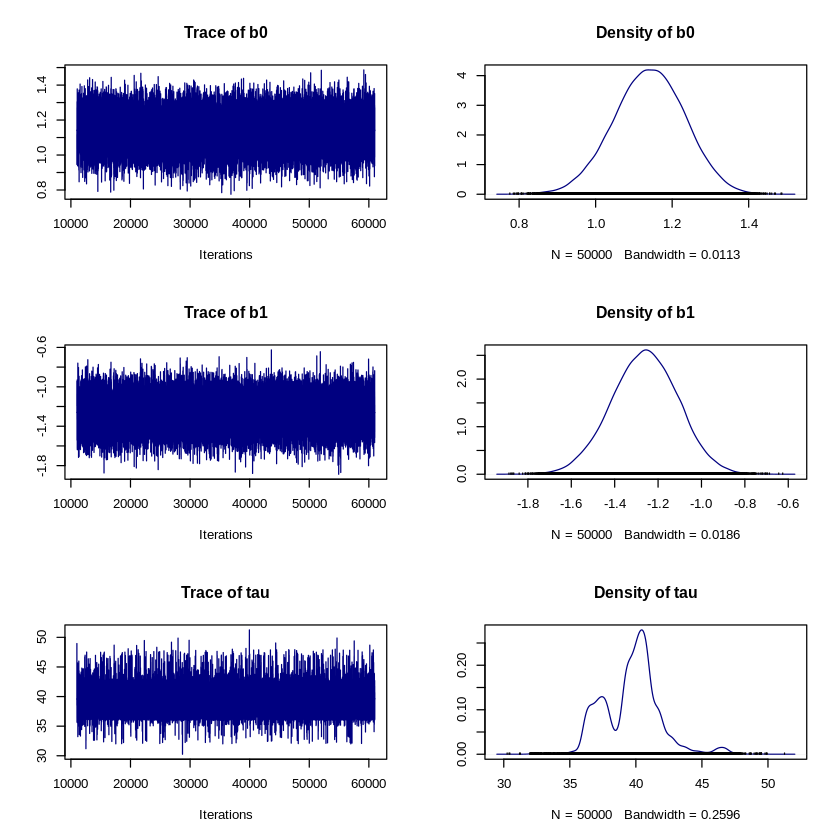

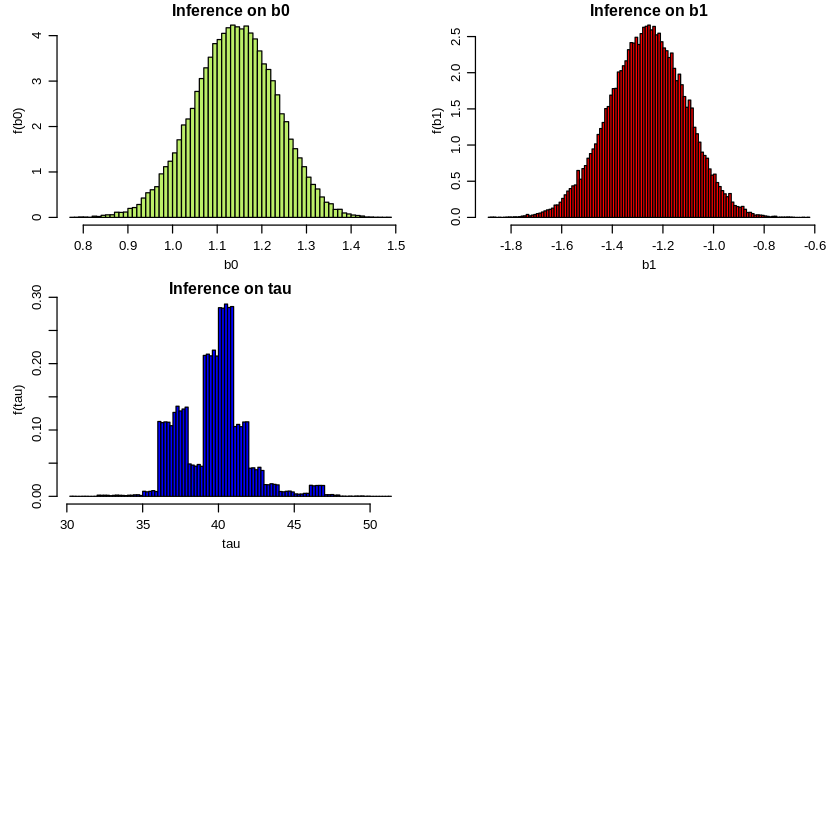

In [54]:
# EX 2

#
# Inference of a Poisson process using JAGS
#
# Modified from : G.d'Agostini,
#     http://www.roma1.infn.it/~dagos/Galileiana/inf_lambda_pred.R
#
#install.packages("rjags")
#packageDescription("rjags")
library(rjags)

#
# - Specify the Generative Model with BUGS

model <- "model_LN.bug"

#
# Our data for the model: the number of observed counts
# 
data <- NULL
data$D<-c( 4 , 5 , 4 , 1 , 0 , 4 , 3 , 4 , 0 , 6 ,3 , 3 , 4 , 0 , 2 , 6 , 3 , 3 , 5 , 4 , 5 , 3 , 1 , 4 , 4 , 1 , 5 , 5 , 3 , 4 , 2 , 5 , 2 , 2 , 3 , 4 , 2 , 1 , 3 , 2 ,1 , 1 , 1 , 1 , 1 , 3 , 0 , 0 , 1 , 0 , 1 , 1 , 0 , 0 , 3 , 1 , 0 , 3 , 2 , 2 ,0 , 1 , 1 , 1 , 0 , 1 , 0 , 1 , 0 , 0 , 0 , 2 , 1 , 0 , 0 , 0 , 1 , 1 , 0 , 2 ,2 , 3 , 1 , 1 , 2 , 1 , 1 , 1 , 1 , 2 , 4 , 2 , 0 , 0 , 0 , 1 , 4 , 0 , 0 , 0 ,1 , 0 , 0 , 0 , 0 , 0 , 1 , 0 , 0 , 1 , 0 , 0 )
data$X <- 112

inits <- NULL
inits$b0    <- 0
inits$b1    <- 0
inits$tau   <- 50

# Create the model and pass the parameters
jm <- jags.model(model, data, inits)

# Update the Markov chain (Burn-in)
update(jm, 10000)

chain <- coda.samples(jm, c("b0", "b1","tau"), n.iter=50000,n.thin=1000)

print(summary(chain))

readline(prompt="Press [enter] to continue")

chain_plot <- TRUE
if (chain_plot) {
  plot(chain, col="navy")
}

readline(prompt="Press [enter] to continue")

#
# Let's format our chain
chain.df <- as.data.frame( as.mcmc(chain) )

prob_plot <- TRUE
if (prob_plot) {
    par(mfrow=c(3,2), mgp=c(2.0,0.8,0), mar=c(3.5,3.5,1,1), oma=0.1*c(1,1,1,1))
    hist(chain.df$b0, nc=100, prob=TRUE, col='darkolivegreen2',xlab='b0', ylab='f(b0)', main='Inference on b0')
    hist(chain.df$b1, nc=100, prob=TRUE, col='red',xlab='b1', ylab='f(b1)', main='Inference on b1')
    hist(chain.df$tau, nc=100, prob=TRUE, col='blue',xlab='tau', ylab='f(tau)', main='Inference on tau')


}

print("We can consider the means as the ones given in the summary table and the confidence intervals as the interval between the 2.5 and 97.5 quantiles given in the table")
